In [ ]:
!pip install flair


In [ ]:
!python3 -m spacy download en_core_web_lg

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import ast

import spacy
from collections import Counter
import flair
from flair.data import Sentence
from flair.models import SequenceTagger
tagger = SequenceTagger.load('ner')

import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
df =pd.read_csv('tweets_01-08-2021.csv')

In [ ]:
df.info()

In [6]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [7]:
df.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,9.845497e+16,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f,NaN,NaN,NaN,NaN
1,1.234653e+18,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f,NaN,NaN,NaN,NaN
2,1.218011e+18,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f,NaN,NaN,NaN,NaN
3,1.304875e+18,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f,NaN,NaN,NaN,NaN
4,1.218160e+18,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f,NaN,NaN,NaN,NaN


In [8]:
df['date'].max()

Timestamp('2053-02-19 00:00:00')

The unnamed columns have date scattered across 4 data columns along with NaN values. After the careful inspection of data, if the column has NaN value across all these 4 unnamed columns then the date column has correct date. Thus, I will drop all columns where any value is present in those columns for the simplicity of the project

In [9]:
df = df[~(df['Unnamed: 9'].notnull() | df['Unnamed: 10'].notnull() | df['Unnamed: 11'].notnull() | df['Unnamed: 12'].notnull() )]


In [10]:
df.shape

(56318, 13)

In [11]:
df['date'].max()

Timestamp('2021-01-08 15:44:28')

In [12]:
df['date'].min()

Timestamp('2009-05-04 18:54:25')

In [13]:
df = df[df['isRetweet']=='f'][['text']]

In [85]:
import re

def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'RT @[\w_]+:', '', tweet)
    tweet = re.sub(r'@[\w_]+', '', tweet)
    tweet= tweet.strip()
    return tweet

df['text'] = df['text'].apply(clean_tweet)

In [87]:
df= df[df['text']!='']

In [89]:
df=df.reset_index()

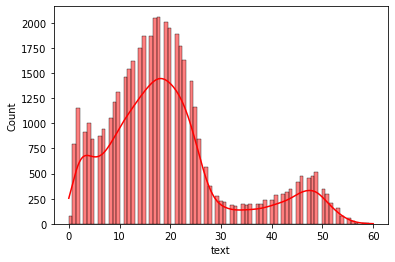

In [18]:
text_length = df['text'].str.split().map(lambda x: len(x))
sns.histplot(text_length.map(lambda x: np.mean(x)), color='red', kde=True)


In [19]:


nlp = spacy.load('en_core_web_lg')

In [24]:
exclude_terms = ['trump', 'country', 'donaldtrump']

def get_orgs_spacy(text):
    doc = nlp(text)
    org_list = []
    for entity in doc.ents:

        if entity.label_ == 'ORG' and entity.text.lower() not in exclude_terms:
            org_list.append(entity.text.lower())

    org_list = list(set(org_list))
    return org_list

In [23]:

def get_orgs(text):
    sentence = Sentence(text)
    tagger.predict(sentence)
    org_list = [entity.text for entity in sentence.get_spans('ner') if entity.tag == 'ORG']

    org_list = list(set(org_list))
    return org_list

In [25]:
df['organizations_flair'] = df['text'].apply(get_orgs)
df.head()

,text,organizations_flair
0,Republicans and Democrats have both created ou...,[]
1,I was thrilled to be back in the Great city of...,[American Patriots]
3,The Unsolicited Mail In Ballot Scam is a major...,[]
6,Getting a little exercise this morning!,[]
14,Thank you Elise!,[]


In [27]:
df['organizations_spacy'] = df['text'].apply(get_orgs_spacy)
df.head()

,text,organizations_flair,organizations_spacy
0,Republicans and Democrats have both created ou...,[],[]
1,I was thrilled to be back in the Great city of...,[American Patriots],"[american patriots, kag2020]"
3,The Unsolicited Mail In Ballot Scam is a major...,[],"[the unsolicited mail in ballot scam, ballots ..."
6,Getting a little exercise this morning!,[],[]
14,Thank you Elise!,[],[]


In [29]:
orgs = df['organizations_flair'].to_list()
orgs = [org for sublist in orgs for org in sublist]

org_freq = Counter(orgs)

sorted_words = org_freq.most_common(20)


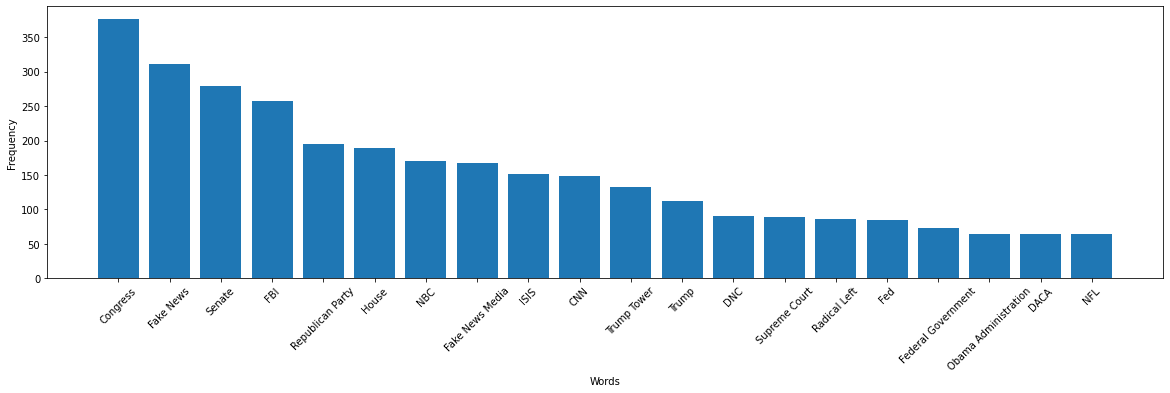

In [30]:
frequencies = [count for _, count in sorted_words]
words = [sentence for sentence, _ in sorted_words]

plt.figure(figsize=(20,5))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

In [ ]:
model = flair.models.TextClassifier.load('en-sentiment')


In [44]:
def get_sentiment(text):
    sentence = flair.data.Sentence(text)
    model.predict(sentence)
    
    sentiment = sentence.labels[0]
    return sentiment

In [ ]:
df['sentiment']= df['text'].apply(get_sentiment)

In [113]:
df.head(10)


,text,organizations_flair,organizations_spacy,sentiment
0,Republicans and Democrats have both created ou...,[],[],"Sentence: ""Republicans and Democrats have both..."
1,I was thrilled to be back in the Great city of...,[American Patriots],"['american patriots', 'kag2020']","Sentence: ""I was thrilled to be back in the Gr..."
2,The Unsolicited Mail In Ballot Scam is a major...,[],"['the unsolicited mail in ballot scam', 'ballo...","Sentence: ""The Unsolicited Mail In Ballot Scam..."
3,Getting a little exercise this morning!,[],[],"Sentence: ""Getting a little exercise this morn..."
4,Thank you Elise!,[],[],"Sentence: ""Thank you Elise !"" → POSITIVE (0.98)"
5,"As per your request, Joe...",[],[],"Sentence: ""As per your request , Joe ..."" → PO..."
6,The threshold identification of Ballots is tur...,[],[],"Sentence: ""The threshold identification of Bal..."
7,"“I’m running as a proud Democrat, for the Sena...",[Senate],['senate'],"Sentence: ""“ I ’m running as a proud Democrat ..."
8,HUGE win today for the United States and for p...,[],[],"Sentence: ""HUGE win today for the United State..."
9,Thank you Megyn!,[],[],"Sentence: ""Thank you Megyn !"" → POSITIVE (0.9814)"


In [111]:
df = df[['text', 'organizations_flair', 'organizations_spacy','sentiment']]

In [112]:
df.to_csv('tweets_with_ner&sentiment.csv')

In [100]:

df['organizations_flair'] = df['organizations_flair'].apply(lambda x: ast.literal_eval(x))

In [101]:
sentiment = {}

for i, row in df.iterrows():
   
    direction = row['sentiment'].value
    score = row['sentiment'].score
    for org in row['organizations_flair']:
        if org not in sentiment.keys():
            sentiment[org] = {'POSITIVE': [], 'NEGATIVE': [], 'FREQUENCY':0}
        sentiment[org][direction].append(score)
        sentiment[org]['FREQUENCY'] +=1

In [102]:
avg_sentiment = []

for org in sentiment.keys():

    frequency = sentiment[org]['FREQUENCY']
    for direction in ['POSITIVE', 'NEGATIVE']:
        score = sentiment[org][direction]
        if len(score) == 0:
            sentiment[org][direction] = 0.0
        else:
            sentiment[org][direction] = sum(score)
    total = sentiment[org]['POSITIVE'] - sentiment[org]['NEGATIVE']
    avg = total/frequency
    avg_sentiment.append({
        'entity': org,
        'positive': sentiment[org]['POSITIVE'],
        'negative': sentiment[org]['NEGATIVE'],
        'frequency': frequency,
        'score': avg 
    })

In [116]:
sentiment_df = pd.DataFrame(avg_sentiment)
sentiment_df

,entity,positive,negative,frequency,score
0,American Patriots,15.945193,0.000000,16,0.996575
1,Senate,104.307160,157.705509,279,-0.191392
2,Surrender Caucus,0.000000,0.999508,1,-0.999508
3,Republican Party,112.754017,71.233578,195,0.212925
4,Town Hall,4.904707,1.997735,7,0.415282
...,...,...,...,...,...
3993,USS Cole,0.996449,0.000000,1,0.996449
3994,Trump-Era High,0.535858,0.000000,1,0.535858
3995,Opposition Party.,0.955660,0.000000,1,0.955660
3996,Delphi,0.000000,0.979524,1,-0.979524


In [117]:
sentiment_df = sentiment_df[sentiment_df['frequency'] > 3]
sentiment_df

,entity,positive,negative,frequency,score
0,American Patriots,15.945193,0.000000,16,0.996575
1,Senate,104.307160,157.705509,279,-0.191392
3,Republican Party,112.754017,71.233578,195,0.212925
4,Town Hall,4.904707,1.997735,7,0.415282
7,ABC,8.454852,33.249919,43,-0.576629
...,...,...,...,...,...
3428,News Media,1.934210,1.703400,4,0.057702
3459,Whistleblower,0.000000,8.943722,9,-0.993747
3518,The Failing New York Times,0.999350,3.942621,5,-0.588654
3666,Radical Left Congresswomen,1.184861,1.999918,4,-0.203764


In [118]:
sentiment_df.sort_values('frequency', ascending=False).head(20)


,entity,positive,negative,frequency,score
60,Congress,156.563989,192.745176,376,-0.096227
30,Fake News,40.077280,262.679005,311,-0.715761
1,Senate,104.307160,157.705509,279,-0.191392
32,FBI,31.376040,213.646155,257,-0.709222
3,Republican Party,112.754017,71.233578,195,0.212925
42,House,66.674942,109.145745,189,-0.224713
10,NBC,86.234388,73.045597,171,0.077127
28,Fake News Media,27.978562,128.503697,167,-0.601947
513,ISIS,31.832860,110.279170,151,-0.519512
99,CNN,35.045364,105.454154,149,-0.472542


In [119]:
sentiment_df.sort_values('score', ascending=True).head(20)


,entity,positive,negative,frequency,score
646,Radical Left Democrat Party,0.0,3.998682,4,-0.999671
2343,T-Mobile,0.0,4.998135,5,-0.999627
13,Republican Poll Watchers,0.0,3.998454,4,-0.999614
2203,Club for Growth,0.0,4.998031,5,-0.999606
3158,Trump News,0.0,3.998414,4,-0.999603
858,Fake News New York Times,0.0,3.998371,4,-0.999593
129,Fake News Washington Post,0.0,4.997175,5,-0.999435
292,Democrat Primary,0.0,3.996995,4,-0.999249
3146,Trump Team,0.0,3.996406,4,-0.999101
2282,Trans-Pacific Partnership,0.0,4.994893,5,-0.998979


In [122]:
sentiment_df.to_csv('entities_score.csv')

In [121]:
sentiment_df.sort_values('score', ascending=False).head(20)


,entity,positive,negative,frequency,score
1537,Baseball Hall of Fame,4.994691,0.0,5,0.998938
2957,Lincoln Memorial,5.990878,0.0,6,0.998480
1045,Mar-a-Lago Club,4.991562,0.0,5,0.998312
1462,Trump Int'l Hotel & amp,5.987437,0.0,6,0.997906
3151,"Crime & amp , Borders",3.988536,0.0,4,0.997134
0,American Patriots,15.945193,0.0,16,0.996575
615,Fox Network,3.985589,0.0,4,0.996397
1446,Trump Int’l Palm Beach,3.985398,0.0,4,0.996350
37,Great American Patriots,3.982188,0.0,4,0.995547
1242,National Achievers Congress,4.974758,0.0,5,0.994952


In [123]:
sentiment_df.nlargest(20, ['score','frequency'])


,entity,positive,negative,frequency,score
1537,Baseball Hall of Fame,4.994691,0.0,5,0.998938
2957,Lincoln Memorial,5.990878,0.0,6,0.998480
1045,Mar-a-Lago Club,4.991562,0.0,5,0.998312
1462,Trump Int'l Hotel & amp,5.987437,0.0,6,0.997906
3151,"Crime & amp , Borders",3.988536,0.0,4,0.997134
0,American Patriots,15.945193,0.0,16,0.996575
615,Fox Network,3.985589,0.0,4,0.996397
1446,Trump Int’l Palm Beach,3.985398,0.0,4,0.996350
37,Great American Patriots,3.982188,0.0,4,0.995547
1242,National Achievers Congress,4.974758,0.0,5,0.994952


In [124]:
sentiment_df.nsmallest(20, ['score','frequency'])


,entity,positive,negative,frequency,score
646,Radical Left Democrat Party,0.0,3.998682,4,-0.999671
2343,T-Mobile,0.0,4.998135,5,-0.999627
13,Republican Poll Watchers,0.0,3.998454,4,-0.999614
2203,Club for Growth,0.0,4.998031,5,-0.999606
3158,Trump News,0.0,3.998414,4,-0.999603
858,Fake News New York Times,0.0,3.998371,4,-0.999593
129,Fake News Washington Post,0.0,4.997175,5,-0.999435
292,Democrat Primary,0.0,3.996995,4,-0.999249
3146,Trump Team,0.0,3.996406,4,-0.999101
2282,Trans-Pacific Partnership,0.0,4.994893,5,-0.998979
